### Testing SHAP and PCA approach
SHapley Additive exPlanations

In [21]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from utils import ModelComparator
from custom_scaler import tree_column_transformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from utils import ModelComparator
from custom_scaler import column_transformer

import warnings
warnings.filterwarnings('ignore')

In [22]:
X_train = pd.read_table('x_train.txt', sep=" ", header=None)
X_train.columns = [str(i) for i in range(X_train.shape[1])]
y_train = pd.read_table('y_train.txt', header=None).to_numpy(dtype=np.int8).squeeze()

In [23]:
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

compute shap

In [25]:
explainer = shap.Explainer(model, X_train, feature_names=[f'v{i}' for i in range(X_train.shape[1])])
shap_values = explainer(X_train)

In [27]:
shap_means = np.abs(shap_values.values).mean(axis=0)
top_k = 3
top_features = np.argsort(shap_means)[-top_k:][::-1]

print("Top features by SHAP importance:", top_features)

Top features by SHAP importance: [  2 462 414]


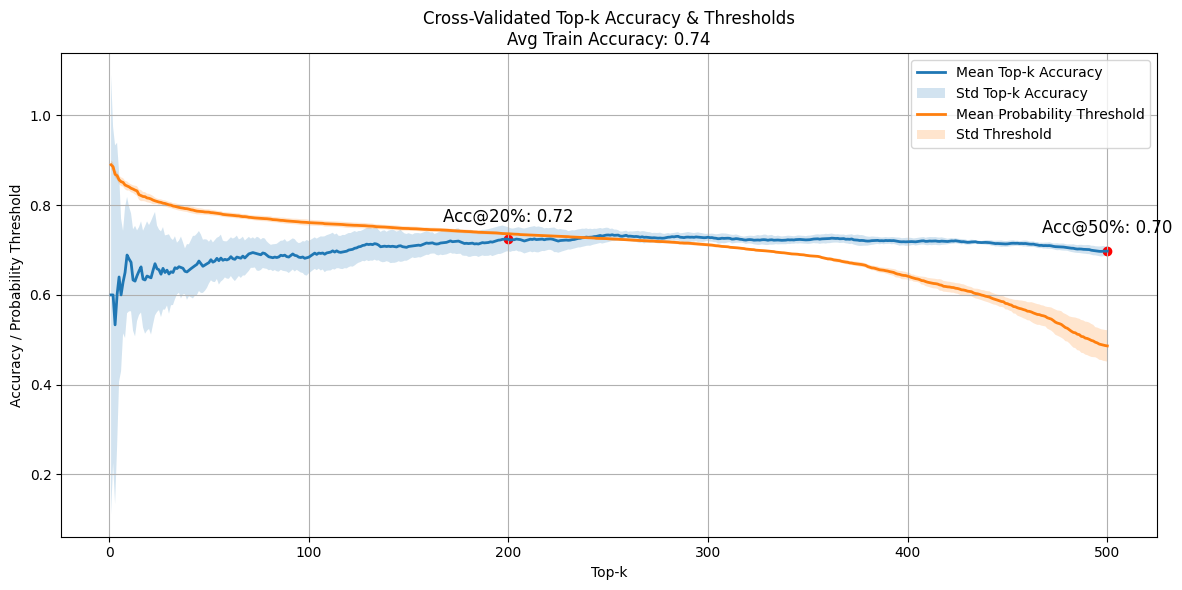

Test Accuracies (Overall): 0.71 ± 0.01
Top-20 Accuracy (k=1000) with 3 SHAP-selected variables: 0.722


In [18]:
mc = ModelComparator(X_train, y_train, scaling="tree")  # tree scaling: minimal transformation
boosted_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
acc_at_20 = mc.evaluate_model(boosted_model, variables=top_features)

print(f"Top-20 Accuracy (k=1000) with {top_k} SHAP-selected variables: {acc_at_20:.3f}")

In [19]:
final_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
final_model.fit(mc.scaler.transform(X_train)[:, top_features], y_train)

GradientBoostingClassifier(random_state=42)

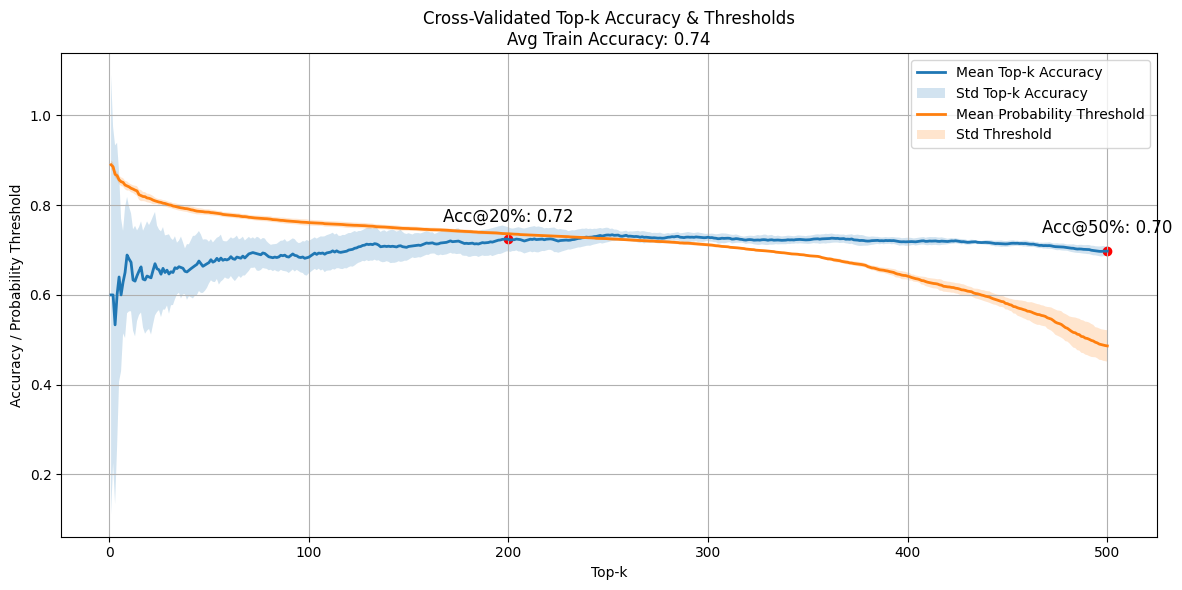

Test Accuracies (Overall): 0.71 ± 0.01


In [20]:
acc_at_3 = mc.evaluate_model(final_model, variables=top_features)

#### PCA 
Principal component analysis

In [34]:
correlated_block = list(range(10))  # Highly correlated block
extra_features = [462, 414]    # Manually chosen 

# Combined indices for logistic regression
X_train_corr = X_train.iloc[:, correlated_block]
X_train_extra = X_train.iloc[:, extra_features]

In [35]:
pca = PCA(n_components=3, random_state=42)
X_train_pca = pca.fit_transform(X_train_corr)

# Combine PCA components with raw extra features
X_train_final = np.hstack([X_train_pca, X_train_extra.values])

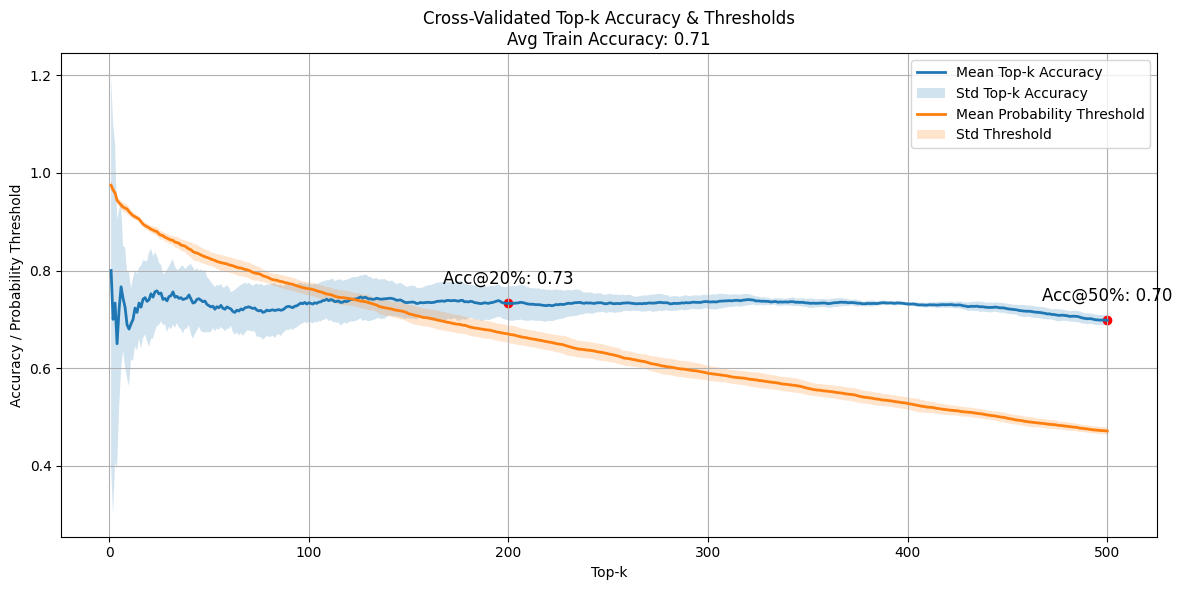

Test Accuracies (Overall): 0.71 ± 0.01
Top-20 Accuracy (k=1000) with 5 variables: 0.732


In [36]:
mc = ModelComparator(X_train_final, y_train, scaling=None)
model = LogisticRegression(max_iter=1000, random_state=42)

acc_at_20 = mc.evaluate_model(model)
print(f"Top-20 Accuracy (k=1000) with {X_train_final.shape[1]} variables: {acc_at_20:.3f}")